# **<center>05_eval_baseline_cnn_vs_ml</center>**

### Table of Contents

1. **Notebook Overview**  
   - Objective of the external evaluation for the experiment 
   - Comparison between the best end-to-end CNN and the hybrid CNN + SVM model  
   - Role of this notebook within the overall experimental pipeline  

2. **Environment Setup**  
   - Import of required libraries and utility functions  
   - Basic configuration for plotting and progress monitoring  

3. **Load Images and Metadata**  
   - 3.1. Definition of base paths for external test subsets  
   - 3.2. Helper functions for image loading and label extraction  
   - 3.3. Discovery of test subsets and construction of per-subset dictionaries  
   - 3.4. Concatenation of all images, labels and metadata into unified arrays/dataframes  

4. **Load Best CNN and CNN–ML Models and Prepare test data for the ML model**  
   - Loading of the best-performing CNN 
   - Loading of the tuned SVM model trained on CNN-extracted features  
   - Preparation of the ML test feature set (`df_test`, `X_test`, `y_test`)  

5. **Model Evaluation on the Test Set**  
   - 5.1. CNN evaluation on the test subset  
     - Global test-set metrics: sensitivity, specificity, PPV, NPV, F1, accuracy, ROC AUC  
     - Analytical confidence intervals for AUC and ROC curve plotting  
     - Saving of metrics and ROC curve to disk  
   - 5.2. ML (SVM) evaluation on the test subset  
     - Same evaluation metrics and ROC analysis for the SVM model  
     - Bootstrap-based confidence intervals for AUC  
     - Saving of metrics and ROC curve to disk  
   - Combined ROC visualisation and joint metrics table for CNN vs SVM
   - 5.3. Statistical comparison between CNN and SVM models (DeLong for AUC)

6. **Model Explainability**  
   - 6.1. Explainability of the CNN model (Grad-CAM)  
     - Generation of Grad-CAM heatmaps for each external subset  
     - Representative examples for true positives, true negatives, false positives and false negatives  
     - Optional full Grad-CAM grids per subset for qualitative inspection  
   - 6.2. Explainability of the ML model (SHAP value and permutation importance and surrogate visualisation)  
     - Permutation importance analysis to rank features according to their contribution to the SVM  

7. **Summary and Conclusions**  
   - Quantitative comparison between CNN and SVM (ROC AUC and DeLong test)  
   - Qualitative analysis of model behaviour via Grad-CAM and feature importance  
   - Implications for the choice between end-to-end CNN and hybrid ML pipelines in this clinical setting  


### **1. Experiment Overview**

In this notebook we perform the external evaluation of the best-performing models for the detection of calcific tendinopathy in rotator cuff radiographs. Specifically, we compare an end-to-end convolutional neural network (CNN) with a hybrid approach in which the CNN is used as a fixed feature extractor and a support vector machine (SVM) performs the final binary classification. Both models are evaluated on the same external test set of radiographs, allowing a direct and statistically sound comparison of their diagnostic performance.

The workflow implemented in this notebook includes:

- Loading all external test subsets, reconstructing the full test set as a single image array (`X_all`), its corresponding label vector (`y_all`), and a combined metadata dataframe.  
- Loading the best CNN model and the best SVM classifier trained on pre-computed CNN features, together with the corresponding tabular test set (`df_test`, `X_test`, `y_test`).  
- Evaluating both models on the external test set: computing standard diagnostic metrics (sensitivity, specificity, PPV, NPV, F1-score, accuracy) and ROC-based measures (AUC with confidence intervals), and saving the results and ROC curves to disk.  
- Building a combined ROC visualisation and a joint metrics table to facilitate side-by-side comparison between the CNN and the SVM model.
- Measuring and comparing inference times for both models, both in total and on a per-sample basis, in order to assess their computational efficiency under identical test conditions.

In addition, the notebook includes a dedicated section on model explainability. For the CNN, Grad-CAM heatmaps are generated for each external subset, highlighting the image regions that drive the model predictions for both correct and incorrect cases. For the SVM, permutation importance is used to provide a global ranking of feature relevance, and an optional 2D PCA + linear SVM surrogate is constructed for illustrative visualisation of the separation between cases and controls. Finally, the ROC AUCs of the two models are formally compared using DeLong’s test on the aligned predictions, and the main findings are summarised in the concluding section.


### **2. Environment Setup: Import required libraries**

In [2]:
# System and utilities
import os
from datetime import datetime
import math
from ast import literal_eval

# Numerical computing and data structures
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from scipy.stats import chi2

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

# Deep Learning 
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D

# Machine Learning and metrics
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.inspection import permutation_importance

import joblib

# Image processing
import cv2

# Progress bars
from tqdm import tqdm


### **3. Load images and metadata**

#### **3.1. Load base paths**

In [2]:
# Base path for the test subsets (cropped images for CNN evaluation)
subsets_path = 'Subsets_v0'

# Path to the test feature set for the Machine Learning model
ml_test_features_path = 'EXP1_ML_test_features.csv'

# Path to the trained Machine Learning model (.pkl)
modelo_path = 'Models/mejor_modelo.pkl'


#### **3.2. Helper functions for image loading and label extraction**

In [3]:
# Helper function to load images

def load_images(images_path):
    """
    Load a list of .npy images into a single NumPy array.
    
    Parameters
    ----------
    images_path : list of str
        List of file paths to .npy images.
    
    Returns
    -------
    np.ndarray
        Stacked NumPy array of images if possible.
        If no images are provided, returns an empty array with shape (0,).
    """
    if len(images_path) == 0:
        print('No image paths provided. Returning empty array.')
        return np.empty((0,))

    X_list = []
    shapes_detected = set()

    for image_path in tqdm(images_path, desc='Loading images'):
        try:
            X_ = np.load(image_path)
            shapes_detected.add(X_.shape)
            X_list.append(X_)
        except Exception as e:
            print(f'Warning: error loading {image_path}: {e}')

    if len(shapes_detected) == 0:
        print('No images were successfully loaded. Returning empty array.')
        return np.empty((0,))

    if len(shapes_detected) > 1:
        print(f'Warning: multiple image shapes detected: {shapes_detected}')
    else:
        print(f'All images share the same shape: {list(shapes_detected)[0]}')

    try:
        # np.stack is safer than np.array in this context
        X = np.stack(X_list)
    except Exception as e:
        print(f'Error converting list to NumPy array: {e}')
        X = np.empty((0,))

    return X


In [4]:
# Helper function to extract labels from metadata

def extract_labels(df, images_path):
    """
    Extract labels for each image based on its file name and a metadata DataFrame.
    
    The DataFrame is expected to contain:
      - 'rx_cod': image identifier (matching the file name without extension)
      - 'label_CalTend': corresponding label for calcific tendinopathy
    
    Parameters
    ----------
    df : pandas.DataFrame
        Metadata DataFrame with at least 'rx_cod' and 'label_CalTend' columns.
    images_path : list of str
        List of image file paths (.npy).
    
    Returns
    -------
    np.ndarray
        Array of labels aligned with the order of images_path.
    """
    # Build a dict: rx_cod -> label
    label_dict = dict(zip(df['rx_cod'], df['label_CalTend']))
    
    # Extract labels based on the file name (without extension)
    y = np.array([
        label_dict[os.path.splitext(os.path.basename(path))[0]]
        for path in images_path
    ])
    
    return y


In [5]:
# Helper function to compute age from birthdate (for ML features)

def calcular_edad(df, columna_fecha='birthdate'):
    """
    Compute age from a birthdate column and add it as a new 'edad' column.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing a birthdate column.
    columna_fecha : str, optional
        Name of the column with birthdates in 'YYYY-MM-DD' format.
    
    Returns
    -------
    pandas.DataFrame
        DataFrame with an additional 'edad' column.
    """
    # Convert the column to datetime
    df[columna_fecha] = pd.to_datetime(df[columna_fecha])

    # Compute age based on today's date
    fecha_actual = pd.to_datetime('today')
    df['edad'] = (fecha_actual - df[columna_fecha]).dt.days // 365

    return df


#### **3.3. Discovery of test subsets and construction of per-subset dictionaries**

In [6]:
# Get the list of all folders inside the subsets directory, ignoring hidden ones
subset_folders = sorted([
    f for f in os.listdir(subsets_path)
    if os.path.isdir(os.path.join(subsets_path, f)) and not f.startswith('.')
])

# Dictionary to store image paths per subset
external_subsets = {}

for folder in subset_folders:
    folder_path = os.path.join(subsets_path, folder)
    image_paths = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith('.npy')
    ]
    image_paths = sorted(image_paths)

    if len(image_paths) == 0:
        print(f'Skipping subset {folder}: no .npy files found.')
        continue

    external_subsets[folder] = image_paths
    print(f'Images in {folder}: {len(image_paths)}')

# Optional: total number of .npy images across all subsets
all_image_paths = [p for paths in external_subsets.values() for p in paths]
print(f'\nTotal images in all subsets: {len(all_image_paths)}')
print(f'Total valid subsets: {len(external_subsets)}')


Images in CZC1198HNN_test: 252
Images in MININT-VSAMOTD_test: 56
Images in RADIOLOGIA-HP_test: 172

Total images in all subsets: 480
Total valid subsets: 3


In [7]:
# Dictionaries to store arrays and DataFrames per subset
X_external_dict = {}
df_external_dict = {}
y_external_dict = {}

for subset_name, image_paths in external_subsets.items():
    print(f'\nLoading images from subset: {subset_name}')
    X_subset = load_images(image_paths)
    
    if X_subset.shape[0] == 0:
        print(f'No images loaded for subset {subset_name}. Skipping this subset.')
        continue

    X_external_dict[subset_name] = X_subset
    print(f'Loaded {X_subset.shape[0]} images from {subset_name}')

    # Load associated CSV metadata for this subset
    csv_path = os.path.join(subsets_path, subset_name + '.csv')
    df_subset = pd.read_csv(csv_path)
    df_external_dict[subset_name] = df_subset
    print(f'Rows in metadata {subset_name}: {df_subset.shape[0]}')

    # Extract labels for this subset
    print(f'Extracting labels for subset: {subset_name}')
    y_subset = extract_labels(df_subset, image_paths)
    y_external_dict[subset_name] = y_subset
    print(f'Labels extracted: {len(y_subset)}')



Loading images from subset: CZC1198HNN_test


Loading images: 100%|████████████████████████| 252/252 [00:01<00:00, 137.06it/s]


All images share the same shape: (512, 512, 3)
Loaded 252 images from CZC1198HNN_test
Rows in metadata CZC1198HNN_test: 252
Extracting labels for subset: CZC1198HNN_test
Labels extracted: 252

Loading images from subset: MININT-VSAMOTD_test


Loading images: 100%|██████████████████████████| 56/56 [00:00<00:00, 166.02it/s]


All images share the same shape: (512, 512, 3)
Loaded 56 images from MININT-VSAMOTD_test
Rows in metadata MININT-VSAMOTD_test: 56
Extracting labels for subset: MININT-VSAMOTD_test
Labels extracted: 56

Loading images from subset: RADIOLOGIA-HP_test


Loading images: 100%|████████████████████████| 172/172 [00:00<00:00, 183.87it/s]


All images share the same shape: (512, 512, 3)
Loaded 172 images from RADIOLOGIA-HP_test
Rows in metadata RADIOLOGIA-HP_test: 172
Extracting labels for subset: RADIOLOGIA-HP_test
Labels extracted: 172


#### **3.4. Concatenation of all images, labels and metadata into unified arrays/dataframes**

In [8]:
# Concatenate image arrays (X)
X_all = np.concatenate(
    [X_external_dict[name] for name in external_subsets.keys()],
    axis=0
)
print(f'Total images (X_all): {X_all.shape}')

# Concatenate label arrays (y)
y_all = np.concatenate(
    [y_external_dict[name] for name in external_subsets.keys()],
    axis=0
)
print(f'Total labels (y_all): {y_all.shape}')

# Concatenate metadata DataFrames
df_all = pd.concat(
    [df_external_dict[name] for name in external_subsets.keys()],
    axis=0
).reset_index(drop=True)
print(f'Total rows in df_all: {df_all.shape}')

# Final consistency check
assert X_all.shape[0] == y_all.shape[0] == df_all.shape[0], \
    "Mismatch between number of images, labels, or metadata rows."


Total images (X_all): (480, 512, 512, 3)
Total labels (y_all): (480,)
Total rows in df_all: (480, 16)


### **4. Load Best CNN and CNN-ML Models and Prepare test data for the ML model**

In [18]:
# Path to the CNN model
model_path = (
    'Models/best_cnn_model.h5'
)


# Load the trained CNN model
cnn_model = load_model(model_path)
print('EXPERIMENT 1 — Best CNN model loaded.')
cnn_model.summary()

# Path to the Machine Learning model (.pkl)
modelo_path = 'Models/mejor_modelo.pkl'

# Load the trained SVM model
svm_model = joblib.load(modelo_path)
print('\nEXPERIMENT 1 — SVM model loaded from:', modelo_path)


EXPERIMENT 1 — Best CNN model loaded.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

EXPERIMENT 1 — SVM model loaded from: Dataset/Machine_Learning/mejor_modelo.pkl


In [19]:
# Prepare test data for the ML model

# Load the test feature set
df_test = pd.read_csv(ml_test_features_path)
print('Raw ML test features loaded:')
display(df_test.head(0))

# Ensure age is available
df_test = calcular_edad(df_test)
print('\nML test features with age column:')
display(df_test.head(0))

# Work on a copy to preserve the original df_test if needed later
df_test_ml = df_test.copy()

# Drop non-feature columns if present
columns_to_drop = ["birthdate", "Unnamed: 0"]
for col in columns_to_drop:
    if col in df_test_ml.columns:
        df_test_ml.drop(columns=[col], inplace=True)

# Separate features (X) and label (y)
X_test = df_test_ml.drop(columns=['label'])
y_test = df_test_ml['label']

# Encode sex as numeric (F -> 0, M -> 1)
if 'sex' in X_test.columns:
    X_test['sex'] = X_test['sex'].map({'F': 0, 'M': 1})
    if X_test['sex'].isnull().any():
        X_test['sex'].fillna(X_test['sex'].mode()[0], inplace=True)

print('\nML test set prepared.')
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


Raw ML test features loaded:


Empty DataFrame
Columns: [Unnamed: 0, feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8, feature_9, feature_10, feature_11, feature_12, feature_13, feature_14, feature_15, feature_16, feature_17, feature_18, feature_19, feature_20, feature_21, feature_22, feature_23, feature_24, feature_25, feature_26, feature_27, feature_28, feature_29, feature_30, feature_31, feature_32, feature_33, feature_34, feature_35, feature_36, feature_37, feature_38, feature_39, feature_40, feature_41, feature_42, feature_43, feature_44, feature_45, feature_46, feature_47, feature_48, feature_49, feature_50, feature_51, feature_52, feature_53, feature_54, feature_55, feature_56, feature_57, feature_58, feature_59, feature_60, feature_61, feature_62, feature_63, feature_64, feature_65, feature_66, feature_67, feature_68, feature_69, feature_70, feature_71, feature_72, feature_73, feature_74, feature_75, feature_76, feature_77, feature_78, feature_79, feature_80, feature_81, feature_82, feature_83, feature_84, feature_85, feature_86, feature_87, feature_88, feature_89, feature_90, feature_91, feature_92, feature_93, feature_94, feature_95, feature_96, feature_97, feature_98, feature_99, ...]
Index: []

[0 rows x 519 columns]


ML test features with age column:


Empty DataFrame
Columns: [Unnamed: 0, feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8, feature_9, feature_10, feature_11, feature_12, feature_13, feature_14, feature_15, feature_16, feature_17, feature_18, feature_19, feature_20, feature_21, feature_22, feature_23, feature_24, feature_25, feature_26, feature_27, feature_28, feature_29, feature_30, feature_31, feature_32, feature_33, feature_34, feature_35, feature_36, feature_37, feature_38, feature_39, feature_40, feature_41, feature_42, feature_43, feature_44, feature_45, feature_46, feature_47, feature_48, feature_49, feature_50, feature_51, feature_52, feature_53, feature_54, feature_55, feature_56, feature_57, feature_58, feature_59, feature_60, feature_61, feature_62, feature_63, feature_64, feature_65, feature_66, feature_67, feature_68, feature_69, feature_70, feature_71, feature_72, feature_73, feature_74, feature_75, feature_76, feature_77, feature_78, feature_79, feature_80, feature_81, feature_82, feature_83, feature_84, feature_85, feature_86, feature_87, feature_88, feature_89, feature_90, feature_91, feature_92, feature_93, feature_94, feature_95, feature_96, feature_97, feature_98, feature_99, ...]
Index: []

[0 rows x 520 columns]


ML test set prepared.
X_test shape: (480, 517)
y_test shape: (480,)


### **5. Model Evaluation on Test Subset**

In [20]:
# AUC confidence interval helpers

def auc_confidence_interval_analytic(y_true, y_score, alpha_values=(0.90, 0.95, 0.99)):
    """
    Compute approximate confidence intervals for ROC AUC using 
    an analytic method (Hanley & McNeil style approximation).
    
    Parameters
    ----------
    y_true : array-like
        True binary labels.
    y_score : array-like
        Predicted scores or probabilities.
    alpha_values : tuple of float, optional
        Confidence levels to compute (e.g., (0.90, 0.95, 0.99)).
    
    Returns
    -------
    auc : float
        Area under the ROC curve.
    ci_dict : dict
        Dictionary with keys like 'CI 90% lower', 'CI 90% upper', etc.
    """
    auc = roc_auc_score(y_true, y_score)
    n1 = sum(y_true)
    n2 = len(y_true) - n1
    q1 = auc / (2 - auc)
    q2 = 2 * auc**2 / (1 + auc)
    se_auc = np.sqrt(
        (auc * (1 - auc) +
         (n1 - 1) * (q1 - auc**2) +
         (n2 - 1) * (q2 - auc**2)) / (n1 * n2)
    )

    # Common z-scores
    z_table = {0.90: 1.6449, 0.95: 1.96, 0.99: 2.5758}
    ci_dict = {}

    for level in alpha_values:
        z = z_table[level]
        delta = z * se_auc
        ci_dict[f'CI {int(level * 100)}% lower'] = max(0, auc - delta)
        ci_dict[f'CI {int(level * 100)}% upper'] = min(1, auc + delta)

    return auc, ci_dict


def auc_confidence_interval_bootstrap(y_true, y_score, n_bootstraps=1000, seed=42):
    """
    Compute bootstrap confidence intervals for ROC AUC.
    
    Parameters
    ----------
    y_true : array-like
        True binary labels.
    y_score : array-like
        Predicted scores or probabilities.
    n_bootstraps : int, optional
        Number of bootstrap samples.
    seed : int, optional
        Random seed for reproducibility.
    
    Returns
    -------
    auc : float
        Area under the ROC curve.
    ci_dict : dict
        Dictionary with keys for 90%, 95% and 99% confidence intervals.
    """
    rng = np.random.RandomState(seed)
    bootstrapped_scores = []

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_score), len(y_score))
        # Need at least one positive and one negative sample in each bootstrap
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_score[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)

    ci_90 = (
        sorted_scores[int(0.05 * len(sorted_scores))],
        sorted_scores[int(0.95 * len(sorted_scores))]
    )
    ci_95 = (
        sorted_scores[int(0.025 * len(sorted_scores))],
        sorted_scores[int(0.975 * len(sorted_scores))]
    )
    ci_99 = (
        sorted_scores[int(0.005 * len(sorted_scores))],
        sorted_scores[int(0.995 * len(sorted_scores))]
    )

    auc = roc_auc_score(y_true, y_score)
    ci_dict = {
        'CI 90% lower': ci_90[0], 'CI 90% upper': ci_90[1],
        'CI 95% lower': ci_95[0], 'CI 95% upper': ci_95[1],
        'CI 99% lower': ci_99[0], 'CI 99% upper': ci_99[1],
    }

    return auc, ci_dict


# --- AUC Confidence Interval Helpers ---

def auc_confidence_interval_analytic(y_true, y_score, alpha_values=(0.90, 0.95, 0.99)):
    """
    Compute approximate confidence intervals for ROC AUC using 
    an analytic method (Hanley & McNeil style approximation).
    """
    auc = roc_auc_score(y_true, y_score)
    n1 = sum(y_true)
    n2 = len(y_true) - n1
    q1 = auc / (2 - auc)
    q2 = 2 * auc**2 / (1 + auc)
    se_auc = np.sqrt(
        (auc * (1 - auc) +
         (n1 - 1) * (q1 - auc**2) +
         (n2 - 1) * (q2 - auc**2)) / (n1 * n2)
    )

    # Common z-scores
    z_table = {0.90: 1.6449, 0.95: 1.96, 0.99: 2.5758}
    ci_dict = {}

    for level in alpha_values:
        z = z_table[level]
        delta = z * se_auc
        ci_dict[f'CI {int(level * 100)}% lower'] = max(0, auc - delta)
        ci_dict[f'CI {int(level * 100)}% upper'] = min(1, auc + delta)

    return auc, ci_dict


def auc_confidence_interval_bootstrap(y_true, y_score, n_bootstraps=1000, seed=42):
    """
    Compute bootstrap confidence intervals for ROC AUC.
    """
    rng = np.random.RandomState(seed)
    bootstrapped_scores = []

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_score), len(y_score))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_score[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)

    ci_90 = (
        sorted_scores[int(0.05 * len(sorted_scores))],
        sorted_scores[int(0.95 * len(sorted_scores))]
    )
    ci_95 = (
        sorted_scores[int(0.025 * len(sorted_scores))],
        sorted_scores[int(0.975 * len(sorted_scores))]
    )
    ci_99 = (
        sorted_scores[int(0.005 * len(sorted_scores))],
        sorted_scores[int(0.995 * len(sorted_scores))]
    )

    auc = roc_auc_score(y_true, y_score)
    ci_dict = {
        'CI 90% lower': ci_90[0], 'CI 90% upper': ci_90[1],
        'CI 95% lower': ci_95[0], 'CI 95% upper': ci_95[1],
        'CI 99% lower': ci_99[0], 'CI 99% upper': ci_99[1],
    }

    return auc, ci_dict

# --- Timing Helper Function ---

def measure_inference_time(model, X, model_type='cnn'):
    """
    Runs prediction on X using the model and measures the elapsed time.
    
    Parameters
    ----------
    model : object
        The trained model (CNN or SVM).
    X : array-like
        The input data for prediction.
    model_type : str, optional
        'cnn' or 'svm' to handle specific prediction calls.
        
    Returns
    -------
    y_pred_prob : array
        The predicted probabilities/scores.
    total_time : float
        Total time taken for inference in seconds.
    time_per_sample : float
        Time taken per single sample in seconds.
    """
    start_time = time.time()
    
    if model_type == 'cnn':
        # CNN prediction logic
        y_pred_prob = model.predict(X).ravel()
        
    elif model_type == 'svm':
        # SVM prediction logic
        if hasattr(model, "predict_proba"):
            y_pred_prob = model.predict_proba(X)[:, 1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X)
            # Scale decision scores to [0, 1]
            y_pred_prob = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
        else:
            raise ValueError("The model does not support predict_proba or decision_function.")
    else:
        # Default fallback
        y_pred_prob = model.predict(X)
        
    end_time = time.time()
    
    total_time = end_time - start_time
    time_per_sample = total_time / len(X)
    
    return y_pred_prob, total_time, time_per_sample

#### **5.1. CNN evaluation on Test Subset**

2026-01-11 07:58:37.063799: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1509949440 exceeds 10% of free system memory.


15/15 [==============================] - 10s 733ms/step

=== Evaluation: Exp1_DL_best_model (CNN) ===
Confusion matrix:
[[228 12]
 [36 204]]

Cut-off threshold: 0.8701
Sensitivity: 0.8500
Specificity: 0.9500
PPV: 0.9444
NPV: 0.8636
F1 score: 0.8947
Accuracy: 0.9000
ROC AUC: 0.9563
CI 90%: [0.9405 – 0.9721]
CI 95%: [0.9374 – 0.9752]
CI 99%: [0.9315 – 0.9811]
Total inference time: 17.1945 sec
Time per sample: 0.035822 sec



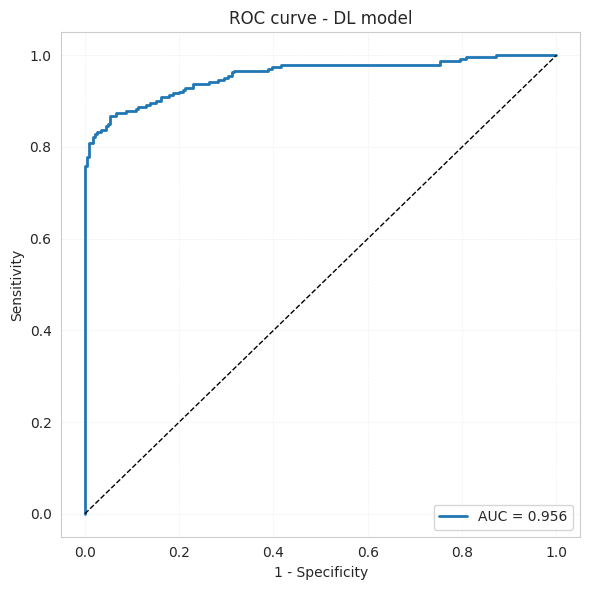

In [25]:
# Output directory for CNN evaluation
save_dir_cnn = 'Evaluation/EXP1/DL'
os.makedirs(save_dir_cnn, exist_ok=True)

# Custom names
evaluation_name_cnn = 'Exp1_DL_best_model'
plot_name_cnn = evaluation_name_cnn + '_ROC.png'
metrics_name_cnn = evaluation_name_cnn + '_metrics.csv'

# Test data for CNN
X_test_cnn = X_all
y_true_cnn = y_all

# --- Predict with Timing ---
# Using the helper function defined previously
y_pred_prob_cnn, total_time_cnn, time_per_sample_cnn = measure_inference_time(
    cnn_model, X_test_cnn, model_type='cnn'
)

# ROC curve
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_true_cnn, y_pred_prob_cnn)

# Select threshold based on clinical criterion (sens >= 0.85 and spec >= 0.70)
best_idx_cnn = None
for i in range(len(thresholds_cnn)):
    sens = tpr_cnn[i]
    spec = 1 - fpr_cnn[i]
    if sens >= 0.85 and spec >= 0.70:
        best_idx_cnn = i
        break

if best_idx_cnn is None:
    print("No clinical threshold found. Using Youden Index.")
    best_idx_cnn = np.argmax(tpr_cnn - fpr_cnn)

best_threshold_cnn = thresholds_cnn[best_idx_cnn]
y_pred_cnn = (y_pred_prob_cnn >= best_threshold_cnn).astype(int)

# Metrics
tn, fp, fn, tp = confusion_matrix(y_true_cnn, y_pred_cnn).ravel()
sensitivity = recall_score(y_true_cnn, y_pred_cnn)
specificity = tn / (tn + fp) if (tn + fp) else 0
ppv = precision_score(y_true_cnn, y_pred_cnn)
npv = tn / (tn + fn) if (tn + fn) else 0
f1 = f1_score(y_true_cnn, y_pred_cnn)
acc = accuracy_score(y_true_cnn, y_pred_cnn)

# AUC and confidence intervals (analytic method)
auc_cnn, ci_dict_cnn = auc_confidence_interval_analytic(y_true_cnn, y_pred_prob_cnn)

# Save metrics to CSV (Added Timing columns)
df_metrics_cnn = pd.DataFrame({
    'Evaluation_name': [evaluation_name_cnn],
    'cut_off_threshold_point': [round(best_threshold_cnn, 4)],
    'tn': [tn], 'fp': [fp], 'fn': [fn], 'tp': [tp],
    'sensitivity': [round(sensitivity, 4)],
    'specificity': [round(specificity, 4)],
    'PPV': [round(ppv, 4)],
    'NPV': [round(npv, 4)],
    'F1 score': [round(f1, 4)],
    'accuracy': [round(acc, 4)],
    'ROC AUC': [round(auc_cnn, 4)],
    'total_inference_time_sec': [round(total_time_cnn, 6)],   # Added
    'time_per_sample_sec': [round(time_per_sample_cnn, 6)],    # Added
    'CI 90% lower': [round(ci_dict_cnn['CI 90% lower'], 4)],
    'CI 90% upper': [round(ci_dict_cnn['CI 90% upper'], 4)],
    'CI 95% lower': [round(ci_dict_cnn['CI 95% lower'], 4)],
    'CI 95% upper': [round(ci_dict_cnn['CI 95% upper'], 4)],
    'CI 99% lower': [round(ci_dict_cnn['CI 99% lower'], 4)],
    'CI 99% upper': [round(ci_dict_cnn['CI 99% upper'], 4)],
    'y_true': [list(y_true_cnn)],
    'y_pred_prob': [list(y_pred_prob_cnn)]
})
df_metrics_cnn.to_csv(os.path.join(save_dir_cnn, metrics_name_cnn), index=False)

# Print metrics
print(f"\n=== Evaluation: {evaluation_name_cnn} (CNN) ===")
print(f"Confusion matrix:\n[[{tn} {fp}]\n [{fn} {tp}]]\n")
print(f'Cut-off threshold: {best_threshold_cnn:.4f}')
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'PPV: {ppv:.4f}')
print(f'NPV: {npv:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'ROC AUC: {auc_cnn:.4f}')
print(f"CI 90%: [{ci_dict_cnn['CI 90% lower']:.4f} – {ci_dict_cnn['CI 90% upper']:.4f}]")
print(f"CI 95%: [{ci_dict_cnn['CI 95% lower']:.4f} – {ci_dict_cnn['CI 95% upper']:.4f}]")
print(f"CI 99%: [{ci_dict_cnn['CI 99% lower']:.4f} – {ci_dict_cnn['CI 99% upper']:.4f}]")
print(f"Total inference time: {total_time_cnn:.4f} sec")
print(f"Time per sample: {time_per_sample_cnn:.6f} sec\n")

# ROC curve plot
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
plt.plot(fpr_cnn, tpr_cnn, linewidth=2, label=f'AUC = {auc_cnn:.3f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve - DL model')
plt.legend(loc='lower right', frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir_cnn, plot_name_cnn), bbox_inches='tight', dpi=300)
plt.show()
plt.close()

#### **5.2. ML (SVM) evaluation on Test Subset**


=== Evaluation: Exp1_ML_SVM (SVM) ===
Confusion matrix:
[[224 16]
 [35 205]]

Cut-off threshold: 0.6921
Sensitivity: 0.8542
Specificity: 0.9333
PPV: 0.9276
NPV: 0.8649
F1 score: 0.8894
Accuracy: 0.8938
ROC AUC: 0.9546
CI 90%: [0.9396 – 0.9680]
CI 95%: [0.9373 – 0.9705]
CI 99%: [0.9288 – 0.9740]
Total inference time: 0.0144 sec
Time per sample: 0.000030 sec

Metrics for the SVM model saved to:
Evaluation/EXP1/ML/Exp1_ML_SVM_metrics.csv


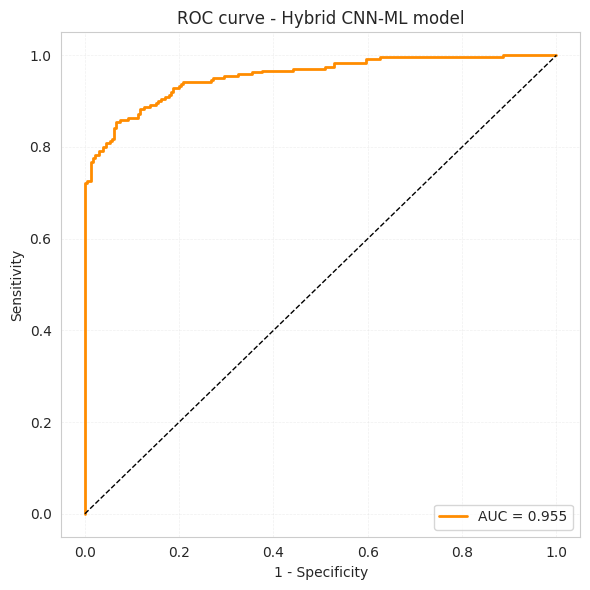


   COMPUTATIONAL EFFICIENCY COMPARISON
The ML (SVM) model is faster than the DL (CNN) model.
Time difference: 17.1801 seconds (Total)
Speedup factor: 1196.46x
----------------------------------------
CNN Time per sample: 0.035822 sec
SVM Time per sample: 0.000030 sec


In [26]:
# Output directory for ML evaluation
save_dir_ml = 'Evaluation/EXP1/ML'
os.makedirs(save_dir_ml, exist_ok=True)

evaluation_name_ml = 'Exp1_ML_SVM'

# Using the helper function to measure SVM time
y_pred_prob_ml, total_time_ml, time_per_sample_ml = measure_inference_time(
    svm_model, X_test, model_type='svm'
)

# ROC curve
fpr_ml, tpr_ml, thresholds_ml = roc_curve(y_test, y_pred_prob_ml)

# Select threshold based on clinical criterion or Youden Index
best_idx_ml = None
for i in range(len(thresholds_ml)):
    sens = tpr_ml[i]
    spec = 1 - fpr_ml[i]
    if sens >= 0.85 and spec >= 0.70:
        best_idx_ml = i
        break

if best_idx_ml is None:
    print("No clinical threshold found. Using Youden Index.")
    best_idx_ml = np.argmax(tpr_ml - fpr_ml)

best_threshold_ml = thresholds_ml[best_idx_ml]
y_pred_ml = (y_pred_prob_ml >= best_threshold_ml).astype(int)

# Metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_ml).ravel()
sensitivity_ml = recall_score(y_test, y_pred_ml)
specificity_ml = tn / (tn + fp) if (tn + fp) else 0
ppv_ml = precision_score(y_test, y_pred_ml)
npv_ml = tn / (tn + fn) if (tn + fn) else 0
f1_ml = f1_score(y_test, y_pred_ml)
acc_ml = accuracy_score(y_test, y_pred_ml)

# AUC and confidence intervals (bootstrap method)
auc_ml, ci_dict_ml = auc_confidence_interval_bootstrap(y_test, y_pred_prob_ml)

# Print metrics
print(f'\n=== Evaluation: {evaluation_name_ml} (SVM) ===')
print(f'Confusion matrix:\n[[{tn} {fp}]\n [{fn} {tp}]]\n')
print(f'Cut-off threshold: {best_threshold_ml:.4f}')
print(f'Sensitivity: {sensitivity_ml:.4f}')
print(f'Specificity: {specificity_ml:.4f}')
print(f'PPV: {ppv_ml:.4f}')
print(f'NPV: {npv_ml:.4f}')
print(f'F1 score: {f1_ml:.4f}')
print(f'Accuracy: {acc_ml:.4f}')
print(f'ROC AUC: {auc_ml:.4f}')
print(f"CI 90%: [{ci_dict_ml['CI 90% lower']:.4f} – {ci_dict_ml['CI 90% upper']:.4f}]")
print(f"CI 95%: [{ci_dict_ml['CI 95% lower']:.4f} – {ci_dict_ml['CI 95% upper']:.4f}]")
print(f"CI 99%: [{ci_dict_ml['CI 99% lower']:.4f} – {ci_dict_ml['CI 99% upper']:.4f}]")
print(f"Total inference time: {total_time_ml:.4f} sec")
print(f"Time per sample: {time_per_sample_ml:.6f} sec")

# Save metrics to CSV (Added Timing columns)
df_metrics_ml = pd.DataFrame({
    'Evaluation_name': [evaluation_name_ml],
    'cut_off_threshold_point': [round(best_threshold_ml, 4)],
    'tn': [tn], 'fp': [fp], 'fn': [fn], 'tp': [tp],
    'sensitivity': [round(sensitivity_ml, 4)],
    'specificity': [round(specificity_ml, 4)],
    'PPV': [round(ppv_ml, 4)],
    'NPV': [round(npv_ml, 4)],
    'F1 score': [round(f1_ml, 4)],
    'accuracy': [round(acc_ml, 4)],
    'ROC AUC': [round(auc_ml, 4)],
    'total_inference_time_sec': [round(total_time_ml, 6)],   
    'time_per_sample_sec': [round(time_per_sample_ml, 6)],   
    'CI 90% lower': [round(ci_dict_ml['CI 90% lower'], 4)],
    'CI 90% upper': [round(ci_dict_ml['CI 90% upper'], 4)],
    'CI 95% lower': [round(ci_dict_ml['CI 95% lower'], 4)],
    'CI 95% upper': [round(ci_dict_ml['CI 95% upper'], 4)],
    'CI 99% lower': [round(ci_dict_ml['CI 99% lower'], 4)],
    'CI 99% upper': [round(ci_dict_ml['CI 99% upper'], 4)],
    'y_true': [list(y_test)],
    'y_pred_prob': [list(y_pred_prob_ml)]
})
csv_path_ml = os.path.join(save_dir_ml, evaluation_name_ml + '_metrics.csv')
df_metrics_ml.to_csv(csv_path_ml, index=False)
print(f"\nMetrics for the SVM model saved to:\n{csv_path_ml}")

# ROC curve plot
plt.figure(figsize=(6, 6))
plt.plot(fpr_ml, tpr_ml, color='darkorange', linewidth=2, label=f'AUC = {auc_ml:.3f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve - Hybrid CNN-ML model')
plt.legend(loc='lower right', frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir_ml, evaluation_name_ml + '_ROC.png'),
            bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# --- EFFICIENCY COMPARISON ---
print("\n" + "="*40)
print("   COMPUTATIONAL EFFICIENCY COMPARISON")
print("="*40)

if 'total_time_cnn' in locals() and 'total_time_ml' in locals():
    # Calculate difference and speedup
    diff_time = abs(total_time_cnn - total_time_ml)
    
    if total_time_ml < total_time_cnn:
        speedup = total_time_cnn / total_time_ml if total_time_ml > 0 else 0
        faster_model = "ML (SVM)"
        slower_model = "DL (CNN)"
    else:
        speedup = total_time_ml / total_time_cnn if total_time_cnn > 0 else 0
        faster_model = "DL (CNN)"
        slower_model = "ML (SVM)"
        
    print(f"The {faster_model} model is faster than the {slower_model} model.")
    print(f"Time difference: {diff_time:.4f} seconds (Total)")
    print(f"Speedup factor: {speedup:.2f}x")
    print("-" * 40)
    print(f"CNN Time per sample: {time_per_sample_cnn:.6f} sec")
    print(f"SVM Time per sample: {time_per_sample_ml:.6f} sec")
    print("="*40)
else:
    print("Could not compare models (one or both timing variables are missing).")

Combined metrics CSV saved to:
big_volume/Tesis_definitivo/Evaluation/EXP1/Exp1_DL_ML_combined_metrics.csv


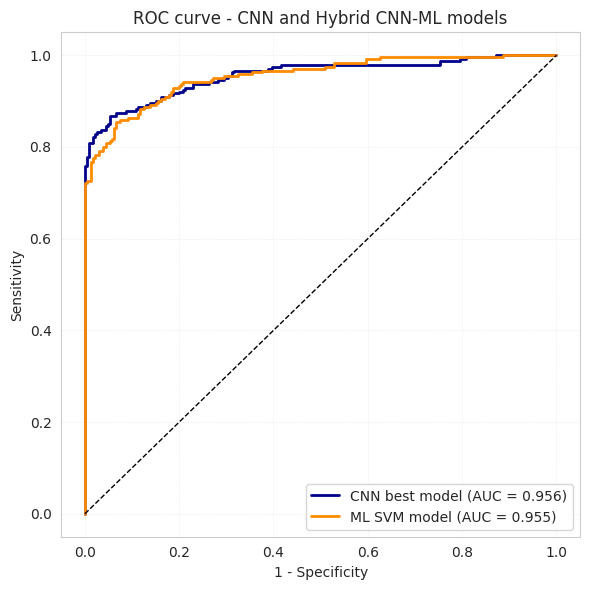

Combined ROC curve saved to:
big_volume/Tesis_definitivo/Evaluation/EXP1/Exp1_DL_ML_ROC.png


In [27]:
# Load individual metrics CSVs 
path_dl = 'Evaluation/EXP1/DL/Exp1_DL_best_model_metrics.csv'
path_ml = 'Evaluation/EXP1/ML/Exp1_ML_SVM_metrics.csv'

df_dl = pd.read_csv(path_dl)
df_ml = pd.read_csv(path_ml)

# Ensure both DataFrames share the same columns (and order)
common_cols = [col for col in df_ml.columns if col in df_dl.columns]
df_dl = df_dl[common_cols]
df_ml = df_ml[common_cols]

# Combine metrics into a single CSV
df_combined = pd.concat([df_dl, df_ml], ignore_index=True)

combined_path = 'big_volume/Tesis_definitivo/Evaluation/EXP1/Exp1_DL_ML_combined_metrics.csv'
df_combined.to_csv(combined_path, index=False)
print(f"Combined metrics CSV saved to:\n{combined_path}")

# Rebuild ROC curves from stored y_true and y_pred_prob 
# Convert list stored as string to numpy arrays
y_true_dl = np.array(literal_eval(df_dl.loc[0, 'y_true']))
y_pred_dl = np.array(literal_eval(df_dl.loc[0, 'y_pred_prob']))

y_true_ml = np.array(literal_eval(df_ml.loc[0, 'y_true']))
y_pred_ml = np.array(literal_eval(df_ml.loc[0, 'y_pred_prob']))

# Compute ROC curves and AUC
fpr_dl, tpr_dl, _ = roc_curve(y_true_dl, y_pred_dl)
auc_dl = roc_auc_score(y_true_dl, y_pred_dl)

fpr_ml, tpr_ml, _ = roc_curve(y_true_ml, y_pred_ml)
auc_ml = roc_auc_score(y_true_ml, y_pred_ml)

# Plot both ROC curves 
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))

# DL curve (dark blue)
plt.plot(
    fpr_dl, tpr_dl,
    color='darkblue', linewidth=2,
    label=f'CNN best model (AUC = {auc_dl:.3f})'
)

# ML curve (orange)
plt.plot(
    fpr_ml, tpr_ml,
    color='darkorange', linewidth=2,
    label=f'ML SVM model (AUC = {auc_ml:.3f})'
)

# Reference diagonal
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

# Grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

# Labels and title
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve - CNN and Hybrid CNN-ML models')

# Visible borders
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(True)

plt.legend(loc='lower right', frameon=True)
plt.tight_layout()

# Save and show
plot_path = 'big_volume/Tesis_definitivo/Evaluation/EXP1/Exp1_DL_ML_ROC.png'
plt.savefig(plot_path, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

print(f"Combined ROC curve saved to:\n{plot_path}")


#### **5.3. Statistical comparison between CNN and SVM models (DeLong for AUC)**

In [63]:
# Column name used as unique identifier for each study/image in both pipelines
ID_COL = 'rx_cod'  

#1. Build an ID list for CNN predictions in the same order as X_all / y_true_cnn ---

ids_all = []
y_all_rebuilt = []

for subset_name in external_subsets.keys():
    image_paths = external_subsets[subset_name]  # list of .npy paths for this subset
    # Extract ID from filename (without extension), e.g. "12345.npy" -> "12345"
    ids_subset = [os.path.splitext(os.path.basename(p))[0] for p in image_paths]
    ids_all.extend(ids_subset)

    # The labels for this subset are in y_external_dict[subset_name]
    y_all_rebuilt.extend(list(y_external_dict[subset_name]))

ids_all = np.array(ids_all)
y_all_rebuilt = np.array(y_all_rebuilt)

# Sanity check: reconstructed labels should match the global CNN test labels
if not np.array_equal(y_all_rebuilt, y_true_cnn):
    print("Warning: reconstructed labels do not match y_true_cnn. "
          "Check subset concatenation consistency.")
else:
    print("CNN labels successfully reconstructed and aligned with y_true_cnn.")

# Build a DataFrame with CNN predictions and IDs
df_cnn_eval = pd.DataFrame({
    ID_COL: ids_all,
    'label': y_true_cnn,
    'y_pred_prob_cnn': y_pred_prob_cnn
})

#2. Build a DataFrame with ML predictions and IDs (recover ID from CSV index) ---

# Read the original features CSV again, keeping the index as rx_cod
df_ml_eval = pd.read_csv(ml_test_features_path, index_col=0)
df_ml_eval.index.name = ID_COL
df_ml_eval.reset_index(inplace=True)

# At this point df_ml_eval has columns: ['rx_cod', feature_1, ..., 'label', 'sex', 'birthdate', ...]
# We now add the predicted probabilities in the *same row order* as used for X_test/y_test
df_ml_eval['y_pred_prob_ml'] = y_pred_prob_ml

# We only need ID, label and ML predicted probabilities
df_ml_eval = df_ml_eval[[ID_COL, 'label', 'y_pred_prob_ml']]

#3. Inner join: keep only cases present in both CNN and ML evaluations ---

df_joint = pd.merge(
    df_cnn_eval,
    df_ml_eval,
    on=ID_COL,
    suffixes=('_cnn', '_ml')
)

print(f"Number of common cases between CNN and ML: {df_joint.shape[0]}")

# Check that labels match between both pipelines
if not np.array_equal(df_joint['label_cnn'], df_joint['label_ml']):
    print("Warning: labels from CNN pipeline and ML pipeline do not match for all cases.")
else:
    print("Labels are consistent between CNN and ML for all common cases.")

# Extract aligned vectors
y_true_aligned = df_joint['label_cnn'].values
y_pred_prob_cnn_aligned = df_joint['y_pred_prob_cnn'].values
y_pred_prob_ml_aligned = df_joint['y_pred_prob_ml'].values

#4. Re-run DeLong test on aligned predictions ---

delong_results_aligned = delong_roc_test(
    y_true=y_true_aligned,
    pred_model_1=y_pred_prob_cnn_aligned,  # CNN
    pred_model_2=y_pred_prob_ml_aligned    # ML
)

auc1 = delong_results_aligned['auc1']
auc2 = delong_results_aligned['auc2']
delta_auc = delong_results_aligned['delta_auc']
z_score = delong_results_aligned['z_score']
p_value = delong_results_aligned['p_value']

print("\n=== DeLong test for ROC AUC comparison (CNN vs ML) on aligned cases ===")
print(f"AUC CNN (model 1): {auc1:.4f}")
print(f"AUC ML  (model 2): {auc2:.4f}")
print(f"Delta AUC (CNN - ML): {delta_auc:.4f}")
print(f"Z-score: {z_score:.4f}")
print(f"P-value (two-sided): {p_value:.4e}")

# Automatic interpretation
alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    if delta_auc > 0:
        better = "The CNN model shows a statistically significant higher AUC than the ML model."
    else:
        better = "The ML model shows a statistically significant higher AUC than the CNN model."
    print(
        f"- At α = {alpha:.2f}, the difference in AUC is statistically significant.\n"
        f"- {better}\n"
        f"- This suggests a meaningful difference in global discriminative performance on this test set."
    )
else:
    direction = "slightly higher" if delta_auc > 0 else "slightly lower"
    print(
        f"- At α = {alpha:.2f}, the difference in AUC is NOT statistically significant.\n"
        f"- The CNN AUC is {direction} than the ML AUC, but the difference (ΔAUC = {delta_auc:.4f}) "
        f"can be explained by random variability.\n"
        f"- Both models show very similar global discriminative performance on this test set."
    )

CNN labels successfully reconstructed and aligned with y_true_cnn.
Number of common cases between CNN and ML: 480
Labels are consistent between CNN and ML for all common cases.

=== DeLong test for ROC AUC comparison (CNN vs ML) on aligned cases ===
AUC CNN (model 1): 0.9563
AUC ML  (model 2): 0.9546
Delta AUC (CNN - ML): 0.0017
Z-score: 0.3734
P-value (two-sided): 7.0885e-01

Interpretation:
- At α = 0.05, the difference in AUC is NOT statistically significant.
- The CNN AUC is slightly higher than the ML AUC, but the difference (ΔAUC = 0.0017) can be explained by random variability.
- Both models show very similar global discriminative performance on this test set.


### **6. Model explainability**

#### **6.1 Explainability of the CNN model (Grad-CAM)**

In [44]:
# Default Grad-CAM configuration
last_conv_layer_name = 'block5_conv4'
classifier_layers = ['global_max_pooling2d', 'dense']


In [49]:
# Cell - Grad-CAM helper functions

def _safe_get_layer(model, name):
    """
    Safely retrieve a layer by name.

    Parameters
    ----------
    model : tf.keras.Model
        Keras model.
    name : str
        Layer name.

    Returns
    -------
    layer or None
        The requested layer, or None if it does not exist.
    """
    try:
        return model.get_layer(name)
    except Exception:
        return None


def _find_last_conv_layer(model):
    """
    Find the last convolutional layer in the model.

    Looks for:
    - Conv2D / SeparableConv2D / DepthwiseConv2D layers
    - Otherwise, falls back to layers with 4D output shapes (H, W, C)
    """
    for layer in reversed(model.layers):
        if isinstance(layer, (Conv2D, SeparableConv2D, DepthwiseConv2D)):
            return layer

        # Fallback: check output shape (must be 4D)
        try:
            out_shape = layer.output_shape
            if isinstance(out_shape, (list, tuple)) and len(out_shape) == 4:
                return layer
        except Exception:
            pass

    return None

def generate_gradcam_heatmaps(
    model,
    X_images,
    last_conv_layer_name='block5_conv4',
    classifier_layer_names=('global_max_pooling2d', 'dense'),
    model_type=2
):
    """
    Generate Grad-CAM heatmaps for a batch of images.

    Parameters
    ----------
    model : tf.keras.Model
        Trained CNN model.
    X_images : numpy.ndarray
        Array of images (assumed to be normalized between 0 and 1).
    last_conv_layer_name : str
        Name of the convolutional layer used for Grad-CAM.
    classifier_layer_names : list or tuple of str
        Names of classifier layers (used if model_type != 2).
    model_type : int
        If 2 → model uses a VGG19 base (handled differently).

    Returns
    -------
    heatmaps_imgs : list of numpy.ndarray
        List of Grad-CAM heatmaps superimposed on the original images.
    preds_all : list of float
        Model prediction scores for each input image.
    """

    heatmaps_imgs = []
    preds_all = []

    # Determine the base model (feature extractor)
    if model_type == 2:
        base_model = _safe_get_layer(model, 'vgg19') or model
    else:
        base_model = model

    # Try the provided conv layer; if not found, fallback to last conv layer
    conv_layer = _safe_get_layer(base_model, last_conv_layer_name)
    if conv_layer is None:
        fallback_conv = _find_last_conv_layer(base_model)
        if fallback_conv is None:
            available = [l.name for l in base_model.layers]
            raise ValueError(
                f"Could not find '{last_conv_layer_name}' nor any convolutional layer. "
                f"Available layers: {available}"
            )
        conv_layer = fallback_conv

    conv_output = conv_layer.output
    conv_model = tf.keras.Model(inputs=base_model.input, outputs=conv_output)

    # Rebuild classifier head using existing layers but forcing Linear activation (Logits)
    # This prevents gradient saturation in very confident predictions
    classifier_input = tf.keras.Input(shape=conv_model.output.shape[1:])
    x = classifier_input

    if model_type == 2:
        x = model.get_layer('global_max_pooling2d')(x)
        original_dense = model.get_layer('dense')
        # Re-create dense layer without activation to get raw Logits
        x = tf.keras.layers.Dense(
            units=original_dense.units,
            weights=original_dense.get_weights(),
            activation=None
        )(x)
    else:
        for i, layer_name in enumerate(classifier_layer_names):
            original_layer = model.get_layer(layer_name)
            if i == len(classifier_layer_names) - 1: # Last layer
                x = tf.keras.layers.Dense(
                    units=original_layer.units,
                    weights=original_layer.get_weights(),
                    activation=None
                )(x)
            else:
                x = original_layer(x)

    classifier_model = tf.keras.Model(classifier_input, x)

    # Compute Grad-CAM per image
    for idx, img in enumerate(X_images):
        # Prepare input and recover original viewable image
        img_input = np.expand_dims(img, axis=0)
        original_image = (np.clip(img, 0, 1) * 255).astype("uint8")

        with tf.GradientTape() as tape:
            conv_output_vals = conv_model(img_input)
            tape.watch(conv_output_vals)
            # Predict logits (raw scores) to ensure non-zero gradients
            logits = classifier_model(conv_output_vals)
            class_channel = logits[:, 0]

        # Actual prediction for the report (applying sigmoid to logits)
        pred_prob = tf.nn.sigmoid(logits).numpy()[0][0]
        preds_all.append(float(pred_prob))

        # Calculate gradients of the logit w.r.t. conv output
        grads = tape.gradient(class_channel, conv_output_vals)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        conv_output_vals = conv_output_vals.numpy()[0]
        pooled_grads_np = pooled_grads.numpy()

        # Weight feature maps by importance
        for i in range(pooled_grads_np.shape[-1]):
            conv_output_vals[:, :, i] *= pooled_grads_np[i]

        # Compute heatmap
        heatmap = np.mean(conv_output_vals, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= (np.max(heatmap) + 1e-10)

        # Invert heatmap, as in the original implementation
        heatmap = 1.0 - heatmap

        # Resize and apply colormap
        heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Overlay Grad-CAM on original image
        superimposed = cv2.addWeighted(heatmap_color, 0.4, original_image, 1.0, 0)
        heatmaps_imgs.append(superimposed)

    return heatmaps_imgs, preds_all

In [50]:
# Generate Grad-CAM heatmaps 

heatmaps_dict = {}
y_true_dict = {}
y_pred_dict = {}

for subset_name in external_subsets.keys():
    X_test_subset = X_external_dict[subset_name]
    y_true_subset = y_external_dict[subset_name]

    print(f'Generating Grad-CAM heatmaps for subset: {subset_name}...')

    heatmaps, preds = generate_gradcam_heatmaps(
        cnn_model,
        X_test_subset,
        last_conv_layer_name=last_conv_layer_name,
        classifier_layer_names=classifier_layers,
        model_type=2
    )

    heatmaps_dict[subset_name] = heatmaps
    y_true_dict[subset_name] = y_true_subset
    y_pred_dict[subset_name] = preds

print("All Grad-CAM heatmaps generated.")


Generating Grad-CAM heatmaps for subset: CZC1198HNN_test...
Generating Grad-CAM heatmaps for subset: MININT-VSAMOTD_test...
Generating Grad-CAM heatmaps for subset: RADIOLOGIA-HP_test...
All Grad-CAM heatmaps generated.


In [51]:
# Plot Grad-CAM heatmaps for all images in each subset
# NOTE: This function is NOT executed in the notebook to avoid output saturation.
# Full visualization of all heatmaps is intentionally skipped.
# A separate function is used to display a small set of representative examples.

def plot_heatmaps_all_subsets(heatmaps_dict, y_true_dict, y_pred_dict, cols=3):
    """
    Plot all Grad-CAM heatmaps for each subset in a grid.

    Parameters
    ----------
    heatmaps_dict : dict
        Dictionary with Grad-CAM heatmaps per subset.
    y_true_dict : dict
        Dictionary with ground-truth labels per subset.
    y_pred_dict : dict
        Dictionary with predicted probabilities per subset.
    cols : int
        Number of columns in the plot grid.
    """
    import math

    for subset_name in heatmaps_dict.keys():
        heatmaps = heatmaps_dict[subset_name]
        y_true = y_true_dict[subset_name]
        y_pred = np.array(y_pred_dict[subset_name])
        num_images = len(heatmaps)
        rows = math.ceil(num_images / cols)

        fig, axs = plt.subplots(rows, cols, figsize=(cols * 7, rows * 7))
        axs = axs.flatten()

        for i, img in enumerate(heatmaps):
            true_label = y_true[i]
            pred_prob = float(y_pred[i])
            pred_label = int(pred_prob >= 0.5)
            correctness = 'True' if pred_label == true_label else 'Error'

            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(
                f'CNN best model\nLabel: {true_label} - {correctness}\nPred: {pred_prob:.3f}',
                fontsize=12
            )

        # Remove unused subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

        plt.suptitle(f'Grad-CAM heatmaps - {subset_name}', fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [49]:
# Plot representative Grad-CAM examples (TP, TN, FP, FN) per subset

def plot_representative_heatmaps(
    heatmaps_dict,
    y_true_dict,
    y_pred_dict,
    max_examples=1,
    threshold=0.5
):
    """
    Display representative Grad-CAM examples for each subset:
    TP = true positive
    TN = true negative
    FP = false positive
    FN = false negative

    Parameters
    ----------
    heatmaps_dict : dict
        Dictionary with Grad-CAM heatmaps per subset.
    y_true_dict : dict
        Dictionary with ground-truth labels per subset.
    y_pred_dict : dict
        Dictionary with predicted probabilities per subset.
    max_examples : int
        Number of examples to display for each class (TP, TN, FP, FN).
    threshold : float
        Decision threshold used to convert probabilities to class labels.
    """

    for subset_name in heatmaps_dict.keys():
        heatmaps = heatmaps_dict[subset_name]
        y_true = y_true_dict[subset_name]
        y_pred = y_pred_dict[subset_name]

        print(f"\nShowing representative examples for subset: {subset_name}")

        # Classification based on probability threshold without rounding
        y_pred = np.array(y_pred)
        pred_labels = (y_pred >= threshold).astype(int)

        # Identify indices for each outcome
        TP = [i for i in range(len(y_true)) if y_true[i] == 1 and pred_labels[i] == 1]
        TN = [i for i in range(len(y_true)) if y_true[i] == 0 and pred_labels[i] == 0]
        FP = [i for i in range(len(y_true)) if y_true[i] == 0 and pred_labels[i] == 1]
        FN = [i for i in range(len(y_true)) if y_true[i] == 1 and pred_labels[i] == 0]

        categories = {
            "True Positives (TP)": TP,
            "True Negatives (TN)": TN,
            "False Positives (FP)": FP,
            "False Negatives (FN)": FN
        }

        # Plot for each category
        for cat_name, indices in categories.items():
            if len(indices) == 0:
                print(f"No cases found for: {cat_name}")
                continue

            num_to_plot = min(max_examples, len(indices))
            fig, axs = plt.subplots(1, num_to_plot, figsize=(7 * num_to_plot, 7))

            if num_to_plot == 1:
                axs = [axs]

            for j, idx in enumerate(indices[:num_to_plot]):
                img = heatmaps[idx]
                true_label = y_true[idx]
                pred_prob = float(y_pred[idx])

                # Avoid displaying exactly 1.000 due to floating-point edge cases
                pred_prob_display = min(pred_prob, 0.999)

                axs[j].imshow(img)
                axs[j].axis('off')
                axs[j].set_title(
                    f"{cat_name}\nTrue: {true_label} | Pred: {pred_prob_display:.3f}",
                    fontsize=14
                )

            plt.suptitle(f"{subset_name} — {cat_name}", fontsize=18)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()



Showing representative examples for subset: CZC1198HNN_test


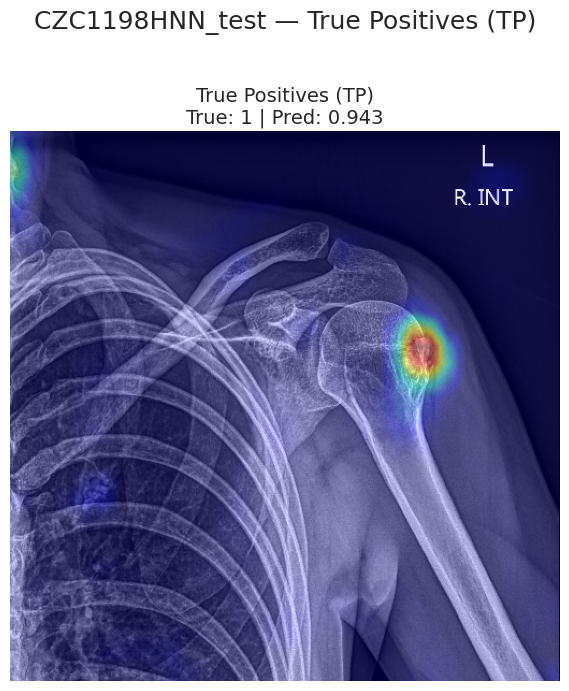

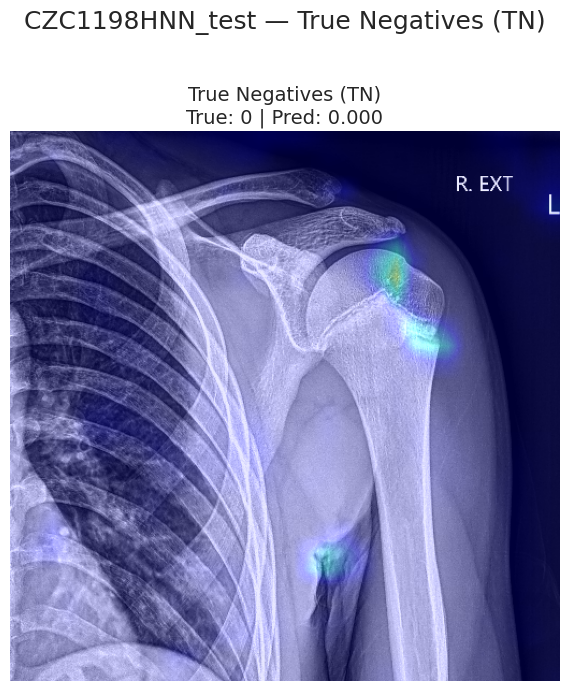

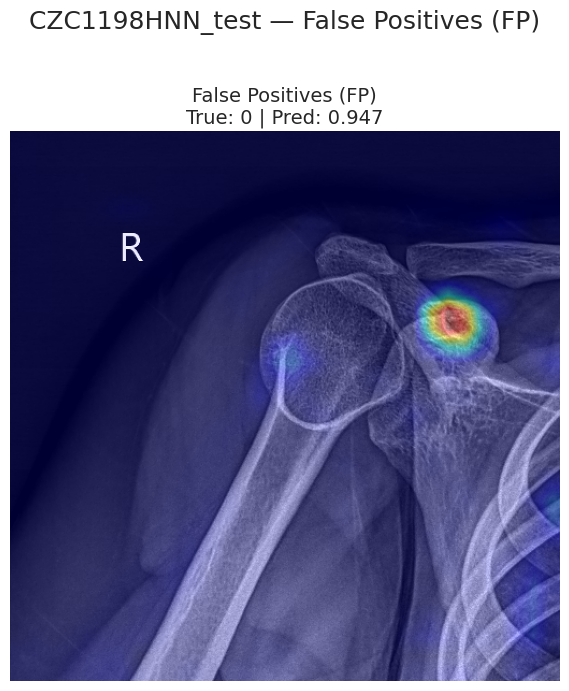

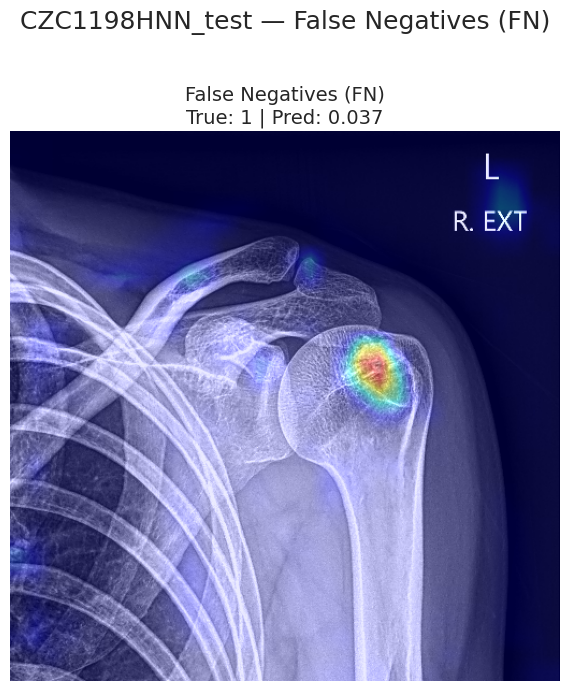


Showing representative examples for subset: MININT-VSAMOTD_test


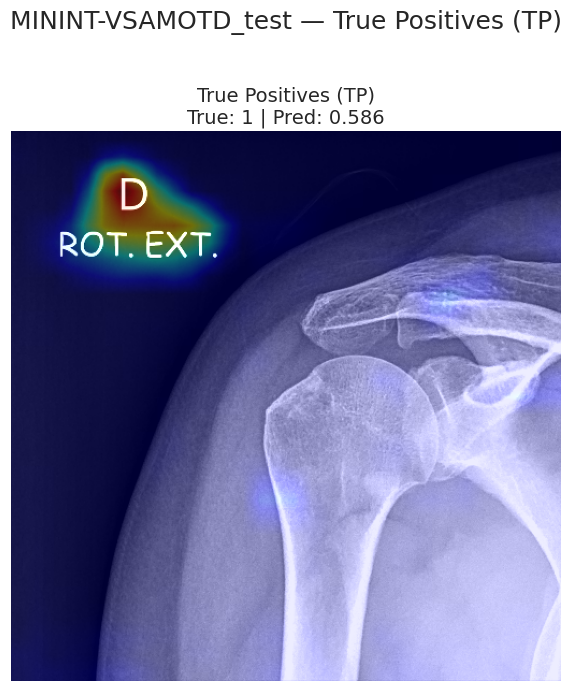

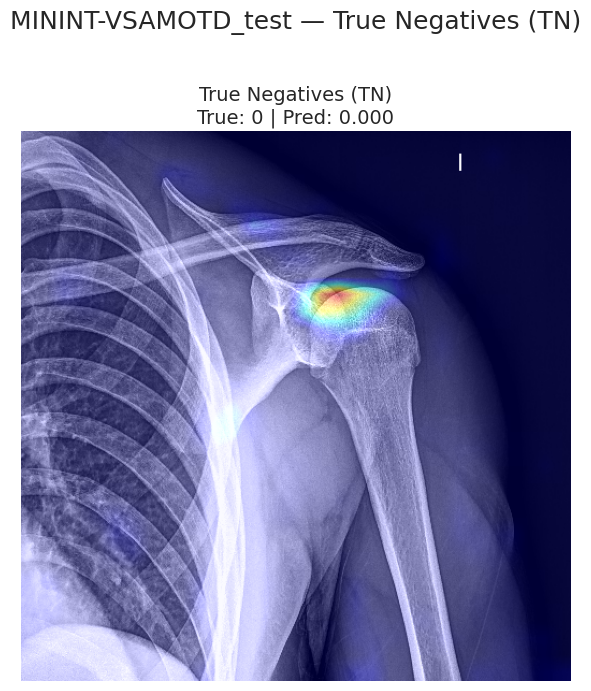

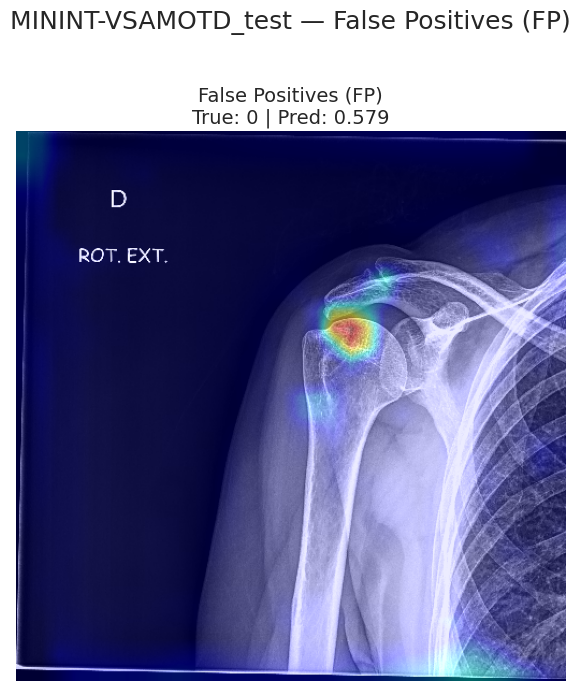

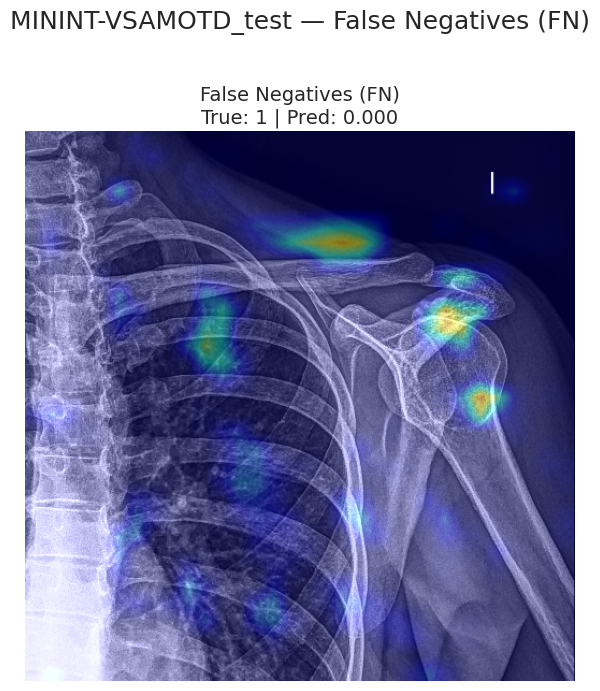


Showing representative examples for subset: RADIOLOGIA-HP_test


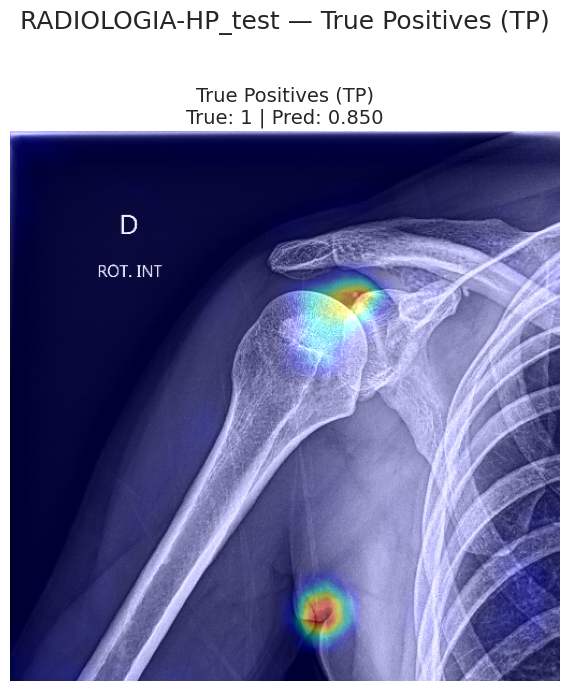

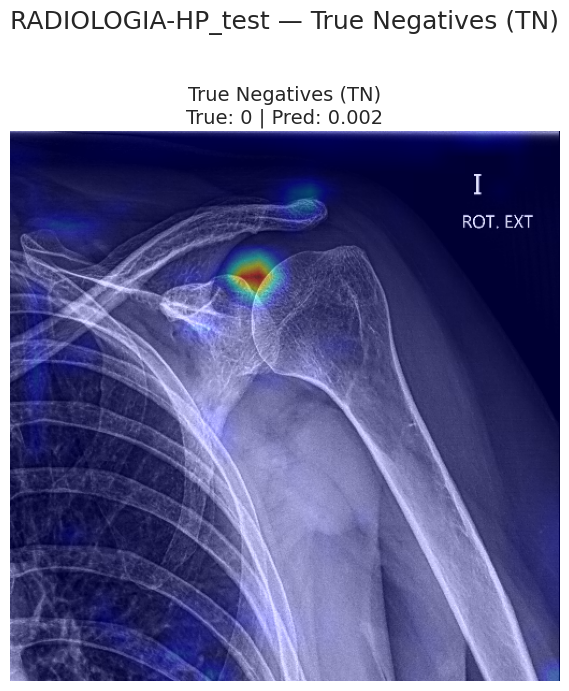

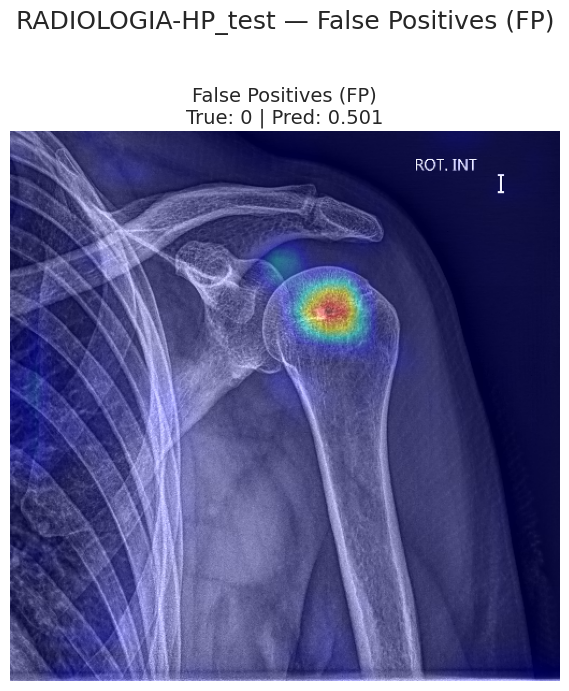

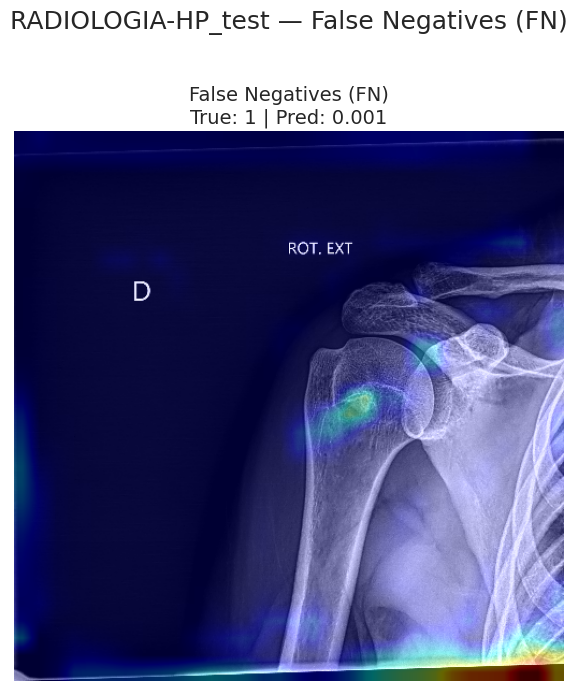

Grad-CAM visualization completed.


In [51]:
# Display representative Grad-CAM heatmaps

plot_representative_heatmaps(
    heatmaps_dict,
    y_true_dict,
    y_pred_dict,
    max_examples=1,
    threshold=0.5  # or threshold=best_threshold_cnn if you want to use the clinical cut-off
)

print("Grad-CAM visualization completed.")


#### **6.1 Explainability of the ML model (SHAP value and permutation importance)**

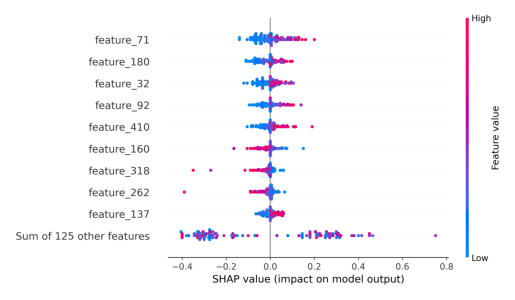

In [3]:
# Number of input features used by the selected model
num_features = X_train_sel.shape[1]

# Minimum number of evaluations required by SHAP
# Rule of thumb: 2 * number_of_features + 1
min_max_evals = 2 * num_features + 1

# Create SHAP explainer with a sufficient number of evaluations
explainer = shap.Explainer(
    best_estimator.predict,
    X_train_sel,
    max_evals=min_max_evals + 100
)

# Explain a subset of the test set to limit computation time
shap_values = explainer(X_test_sel[:100])

# Generate SHAP beeswarm plot
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, max_display=10, show=False)

# Save the figure to disk
output_path = "SHAP.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the figure in the notebook
plt.show()
plt.close()

Top 10 features by permutation importance:
         feature  importance_mean  importance_std
91    feature_92         0.014458        0.006144
179  feature_180         0.013375        0.006097
70    feature_71         0.012167        0.006876
151  feature_152         0.011708        0.004767
409  feature_410         0.011500        0.006862
185  feature_186         0.011125        0.005600
248  feature_249         0.011083        0.006242
136  feature_137         0.011042        0.005532
264  feature_265         0.010375        0.002618
275  feature_276         0.009375        0.002983


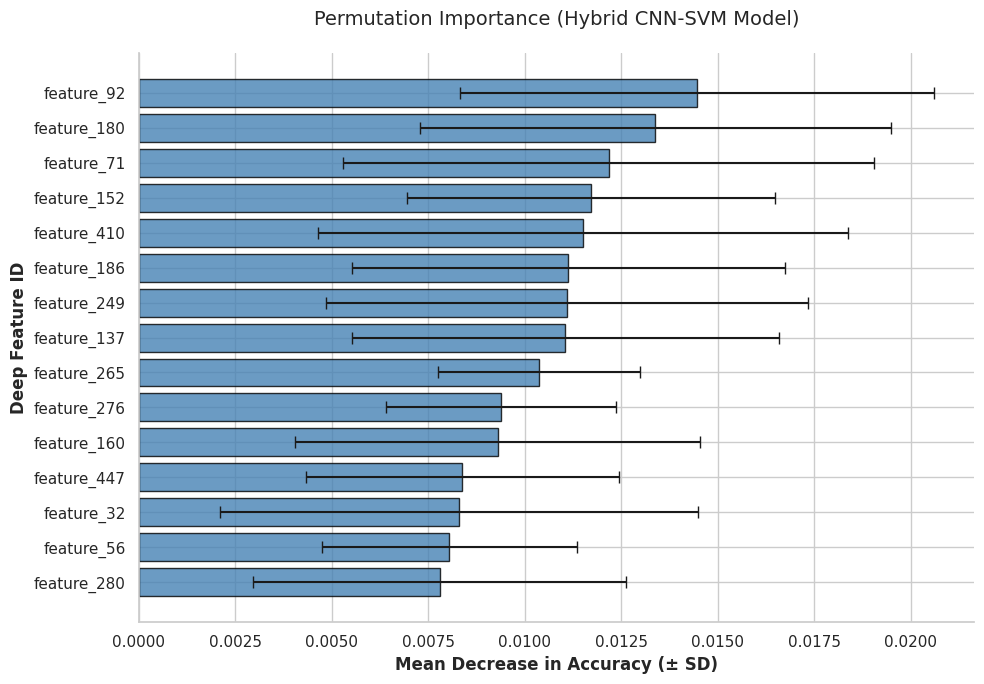

In [30]:
# Set plotting style for academic publication
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# 1. Compute permutation importance on the test set
# We use 50 repeats to ensure statistical robustness
result = permutation_importance(
    svm_model, 
    X_test, 
    y_test, 
    n_repeats=50, 
    random_state=42, 
    n_jobs=-1
)

# 2. Organize results into a DataFrame
# Including both mean and std allows for error bar plotting
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Display Top 10 for console logging
print("Top 10 features by permutation importance:")
print(importance_df.head(10))

# 3. Plotting the top-k features
top_k = 15
top_features = importance_df.head(top_k).copy()

plt.figure(figsize=(10, 7))

# Create horizontal bar plot with error bars (representing standard deviation across repeats)
plt.barh(
    top_features['feature'][::-1], 
    top_features['importance_mean'][::-1], 
    xerr=top_features['importance_std'][::-1],
    color='#4682B4',  # SteelBlue color for a professional look
    capsize=4,        # Error bar caps
    edgecolor='black',
    alpha=0.8
)

# Labeling and formatting
plt.xlabel('Mean Decrease in Accuracy (± SD)', fontsize=12, fontweight='bold')
plt.ylabel('Deep Feature ID', fontsize=12, fontweight='bold')
plt.title('Permutation Importance (Hybrid CNN-SVM Model)', fontsize=14, pad=20)

# Clean up layout
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# Save for Supplementary Material
plt.savefig("Supplementary_Fig_Permutation_Importance.png", dpi=300, bbox_inches="tight")
plt.show()

### **7. Summary and Conclusions**

In this notebook we externally evaluated the best end-to-end CNN model and the best hybrid CNN–SVM model on a common prospective test set of 480 shoulder radiographs. Both models showed excellent discriminative performance for the detection of calcific tendinopathy, with ROC AUC values above 0.95. For the CNN, the AUC on the external test set was approximately 0.956, whereas the SVM model trained on CNN-extracted features achieved an AUC of approximately 0.955. At clinically motivated operating points, both models reached high sensitivity and acceptable specificity, and the corresponding ROC curves were almost overlapping.

To formally assess whether the small numerical difference in AUC reflected a genuine performance gap or simply random variability, we applied DeLong’s test for correlated ROC curves on the aligned predictions. The resulting difference in AUC (ΔAUC ≈ 0.0017) was not statistically significant (Z ≈ 0.37, p ≈ 0.71), indicating that there is no evidence that either the CNN or the SVM model is superior in terms of global discriminative ability on this external test set. In practical terms, this suggests that both the end-to-end CNN and the hybrid CNN–SVM pipeline achieve very similar overall diagnostic performance when evaluated under the same conditions.

Beyond aggregate metrics, we explored model behaviour through explainability analyses. Grad-CAM heatmaps computed for the CNN highlighted image regions that contributed most to the predictions, providing intuitive visual explanations for true positives, true negatives, false positives and false negatives across external subsets. This helped to confirm that, in correctly classified cases, the CNN tends to focus on the regions containing calcific deposits, while also revealing some plausible failure modes in misclassified examples. For the SVM model, permutation importance offered a global ranking of feature relevance, showing which CNN-derived features (and accompanying metadata) have the largest impact on the decision boundary.

In addition to predictive performance, we explicitly compared the computational efficiency of both approaches at inference time. While the CNN requires approximately 0.036 seconds per image, the hybrid SVM model operates several orders of magnitude faster once features are extracted, with an average inference time of approximately 3 × 10⁻⁵ seconds per sample. This corresponds to a speedup of more than three orders of magnitude in favour of the SVM classifier.

Overall, this evaluation notebook shows that both the end-to-end CNN and the hybrid CNN–SVM model provide robust and comparable performance for the detection of calcific tendinopathy in rotator cuff radiographs on an external test set. The CNN has the advantage of offering pixel-level visual explanations via Grad-CAM, whereas the hybrid model naturally lends itself to feature-level importance analyses. The choice between these two strategies in a clinical deployment scenario may therefore depend less on pure performance metrics and more on practical considerations such as interpretability requirements, integration with existing systems and computational constraints.